# The Data

### The features are:

1. Location - {'US', 'EU'} - 70:30 
2. Education - {'GRAD','POST_GRAD'} - 80:20
3. Experience - years - (0, 50)  - normal
4. Engineer Type - {'Software','Hardware'} - 85:15
5. Age - years - (18, 65) - not used directly in the model  - normal
6. Gender - {'M', 'F', 'NB'} - not used directly in the model  - 45:45:10
7. Relevant Experience - years - (0, 50)  - normal

Dataset size 10,000 rows

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# pytorch relates imports
import torch
import torch.nn as nn
import torch.optim as optim
np.random.seed(0)

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from drift_utils import drift_metrics, drift_attribution, data_generation_utils

In [4]:
df = pd.DataFrame(columns=['job_location', 'education', 'experience', 'engg_type', 'age', 'gender', 'relevant_exp'])
DATASET_SIZE = 10000

In [5]:
location_prob  = 0.7
df['job_location'] = np.random.binomial(1, location_prob, (DATASET_SIZE, 1))[:,0]
df['job_location']  = df['job_location'].apply(lambda x: 'A' if x == 1 else 'B').astype('category')

In [6]:
education_prob  = 0.4
df['education'] = np.random.binomial(1, education_prob, (DATASET_SIZE, 1))[:,0]
df['education']  = df['education'].apply(lambda x: 'POST_GRAD' if x == 1 else 'GRAD')

In [7]:
engg_prob  = 0.85
df['engg_type'] = np.random.binomial(1, engg_prob, (DATASET_SIZE, 1))[:,0]
df['engg_type']  = df['engg_type'].apply(lambda x: 'SOFTWARE' if x == 1 else 'HARDWARE').astype('category')

In [8]:
gender_prob  = 0.5
df['gender'] = np.random.binomial(1, gender_prob, (DATASET_SIZE, 1))[:,0]
df['gender']  = df['gender'].apply(lambda x: 'M' if x == 1 else 'F').astype('category')

In [9]:
age = np.random.normal(35, 10, size=DATASET_SIZE)
age = np.clip(age, 18, 60)
df['age'] = np.round(age, 2)

experience = np.clip(age - 30 + np.random.randn(DATASET_SIZE), 0, 40)
df['experience'] = np.round(experience, 2)

relevant_experience = np.clip(experience - np.abs(np.random.randn(DATASET_SIZE)), 0, 40)
df['relevant_exp'] = np.round(relevant_experience, 2)

In [10]:
df

,job_location,education,experience,engg_type,age,gender,relevant_exp
0,A,POST_GRAD,0.00,SOFTWARE,22.70,M,0.00
1,B,GRAD,0.00,SOFTWARE,29.43,M,0.00
2,A,GRAD,0.00,HARDWARE,26.57,F,0.00
3,A,GRAD,4.78,SOFTWARE,34.53,M,4.00
4,A,GRAD,1.47,HARDWARE,32.88,M,0.40
...,...,...,...,...,...,...,...
9995,A,POST_GRAD,0.00,SOFTWARE,30.55,M,0.00
9996,A,GRAD,0.00,SOFTWARE,18.00,M,0.00
9997,B,GRAD,13.13,HARDWARE,42.04,M,12.08
9998,A,GRAD,5.08,SOFTWARE,34.94,F,5.06


# The model

### The model (inferred real world relation between Y (the salary of an applicant) and X (the input features)) is

Salary = 50,000 + 20,000 * location + 20,000 * education+ 5,000 * relevant_experience + 100 * experience + 10,000 * engineer_type


In [11]:
def transform_input(input_df):
    transformed_df = input_df.copy(deep=True)
    transformed_df['job_location'] = transformed_df['job_location'].apply(lambda x: 1 if x == 'A' else 0).astype('int')
    transformed_df['education'] = transformed_df['education'].apply(lambda x: 1 if x == 'POST_GRAD' else 0).astype('int')
    transformed_df['engg_type'] = transformed_df['engg_type'].apply(lambda x: 1 if x == 'SOFTWARE' else 0).astype('int')
    if 'gender' in input_df.columns.tolist():
        transformed_df['gender'] = transformed_df['gender'].apply(lambda x: 1 if x == 'M' else 0).astype('int')

    return transformed_df

transformed_df = transform_input(df)

df['salary'] = 50000 + \
               20000*transformed_df['job_location'] + \
               20000*transformed_df['education'] + \
               5000*transformed_df['relevant_exp'] + \
               100*transformed_df['experience'] + \
               10000*transformed_df['engg_type']

In [12]:
class LinearModel(nn.Module):
    def __init__(self, w):
        super().__init__()
        m = len(w)
        self.linear = nn.Linear(m, 1, bias=False)
        self.linear.weight.data = w

    def forward(self, input):
        #print(self.linear(input))
        return 50000 + self.linear(input)
    
def model_linear(X):
    w = torch.tensor([20000, 20000, 5000, 100, 10000], dtype=torch.float64)
    return LinearModel(w)(torch.tensor(X, dtype=torch.float64, requires_grad=True))

In [13]:
feature_cols = ['job_location', 'education', 'relevant_exp', 'experience', 'engg_type']
df_tensor = torch.tensor(transform_input(df[feature_cols]).values)

In [14]:
sum(df['salary'].values != model_linear(df_tensor).detach().numpy())

/home/avijit/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


6

### Use this site to change the start and end times as per taste
https://currentmillis.com/

In [259]:
from copy import deepcopy
cols = feature_cols + ['time_stamp', 'salary', 'day']
monitoring_df = pd.DataFrame(columns=cols)
monitoring_df

,job_location,education,relevant_exp,experience,engg_type,time_stamp,salary,day


In [260]:
# 15th Jan 2021 00:00:00 PST 
# 16th Jan 2021 00:00:00 PST 

start_time = 1610697600000
end_time = 1610784000000
DATALOG_SIZE = 20000

all_cols = feature_cols + ['gender']
sampled_df = df[all_cols].sample(DATALOG_SIZE, replace=True, random_state=1)
sampled_df['time_stamp'] = np.linspace(start_time, end_time, DATALOG_SIZE).astype(int)
sampled_df = transform_input(sampled_df)
sampled_df['salary'] = model_linear(sampled_df[feature_cols].values).detach().numpy()
sampled_df['day'] = 1
monitoring_df = monitoring_df.append(sampled_df)


### This cell introduces a couple of data integrity issues

1. 'us' instead of 'US'. This makes all job locations 'EU' and reduces the salary by 20k
2. 'post_grad' instead of 'POST_GRAD'. This makes everyone a 'GRAD' and also reduces the salary by 20k

In [261]:
# 16th Jan 2021 00:00:00 PST 
# 17th Jan 2021 00:00:00 PST 

start_time = 1610784000000
end_time = 1610870400000
DATALOG_SIZE = 20000

def applyBias(gender, education):
    if gender == 'M':
        return education
    else:
        return 'post_grad'
    
messed_up_df = df[all_cols].copy(deep=True)
#messed_up_df['job_location'] = messed_up_df['job_location'].apply(lambda x: 'a' if x == 'A' else 'B')
#messed_up_df['education'] = messed_up_df['education'].apply(lambda x: 'post_grad' if x == 'POST_GRAD' else 'GRAD')

messed_up_df['education'] = messed_up_df.apply(lambda x: applyBias(x['gender'], x['education']), axis=1)

sampled_df = messed_up_df.sample(DATALOG_SIZE, replace=True, random_state=2)
sampled_df['time_stamp'] = np.linspace(start_time, end_time, DATALOG_SIZE).astype(int)
sampled_df = transform_input(sampled_df)

sampled_df['salary'] = model_linear(sampled_df[feature_cols].values).detach().numpy()
sampled_df['day'] = 2

monitoring_df = monitoring_df.append(sampled_df)


In [262]:
messed_up_df

,job_location,education,relevant_exp,experience,engg_type,gender
0,A,POST_GRAD,0.00,0.00,SOFTWARE,M
1,B,GRAD,0.00,0.00,SOFTWARE,M
2,A,post_grad,0.00,0.00,HARDWARE,F
3,A,GRAD,4.00,4.78,SOFTWARE,M
4,A,GRAD,0.40,1.47,HARDWARE,M
...,...,...,...,...,...,...
9995,A,POST_GRAD,0.00,0.00,SOFTWARE,M
9996,A,GRAD,0.00,0.00,SOFTWARE,M
9997,B,GRAD,12.08,13.13,HARDWARE,M
9998,A,post_grad,5.06,5.08,SOFTWARE,F


In [263]:
# 17th Jan 2021 00:00:00 PST 
# 18th Jan 2021 00:00:00 PST 

start_time = 1610870400000
end_time = 1610956800000
DATALOG_SIZE = 20000

sampled_df = df[all_cols].sample(DATALOG_SIZE, replace=True, random_state=3)
sampled_df['time_stamp'] = np.linspace(start_time, end_time, DATALOG_SIZE).astype(int)
sampled_df = transform_input(sampled_df)

sampled_df['salary'] = model_linear(sampled_df[feature_cols].values).detach().numpy()
sampled_df['day'] = 3

monitoring_df = monitoring_df.append(sampled_df)


In [264]:
monitoring_df.reset_index(inplace=True)


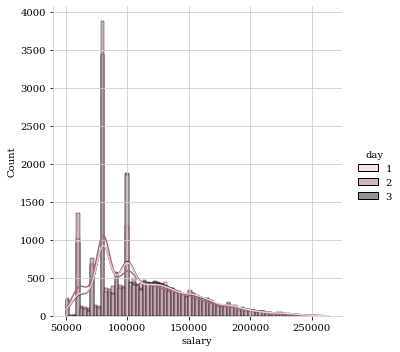

In [265]:
sns.displot(data=monitoring_df, x="salary", hue="day", kde=True)

In [266]:
monitoring_df

,index,job_location,education,relevant_exp,experience,engg_type,time_stamp,salary,day,gender
0,235,1,1,14.67,15.13,1,1610697600000,174863.0,1,1.0
1,5192,1,0,0.00,0.00,1,1610697604320,80000.0,1,1.0
2,905,0,0,0.35,2.05,1,1610697608640,61955.0,1,1.0
3,7813,0,0,7.83,8.71,1,1610697612960,100021.0,1,0.0
4,2895,1,1,13.62,13.95,0,1610697617280,159495.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...
59995,9247,0,0,0.00,0.00,1,1610956782719,60000.0,3,1.0
59996,1711,1,0,0.00,0.00,1,1610956787039,80000.0,3,0.0
59997,886,0,0,2.98,3.93,1,1610956791359,75293.0,3,0.0
59998,3566,1,0,6.05,6.20,1,1610956795679,110870.0,3,0.0


In [267]:
monitoring_df.groupby(['gender','day']).mean()

index  relevant_exp  experience         salary
gender day                                                      
0.0    1    4973.647767      6.482698    7.021339  113477.941735
       2    4983.860546      6.401769    6.938160  105057.870132
       3    4909.478066      6.433521    6.963564  113023.119566
1.0    1    5047.256130      6.441744    6.967987  113298.857376
       2    5030.853269      6.482778    7.024244  113649.606153
       3    5045.037097      6.452797    6.990782  113557.211320

### Other metrics

In [299]:
mdf_day1 = monitoring_df[monitoring_df['day'] == 2]

def labelgen(n):
    threshold = 200000
    if n>threshold:
        return 1
    else:
        return 0
    
mdf_day1['label'] = mdf_day1['salary'].apply(labelgen)

In [300]:
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset

In [301]:
privileged_groups = [{'gender': 1}]
unprivileged_groups = [{'gender': 0}]

binaryLabelDataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=mdf_day1,
    label_names=['label'],
    protected_attribute_names=['gender'])

metric_orig_train = BinaryLabelDatasetMetric(binaryLabelDataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Statistical difference" , metric_orig_train.mean_difference())
print("Disparate Impact" , metric_orig_train.disparate_impact())

Statistical difference -0.01049500132398435
Disparate Impact 0.6554431791242081


### Plot this for day 2 (fairness drift) and for either of day 1 or 3 (no drift)

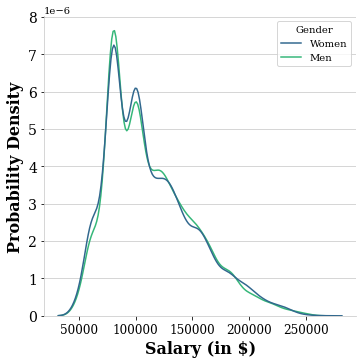

In [273]:
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams['axes.edgecolor'] = "#cccccc"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
plt.rcParams["font.family"] = 'DejaVu Serif'
plt.rcParams["figure.figsize"] = (7.5,5)

g = sns.displot(data=monitoring_df[monitoring_df['day'] == 3], kind="kde", 
            x="salary", hue="gender", palette = 'viridis', facet_kws={'legend_out': False})

ax = plt.gca()
ax.set_facecolor('white')
# ax.get_legend().remove()
ax.xaxis.grid(False)
# if log == True:
#     ax.set(yscale="symlog")
ax.yaxis.grid(True,which='both')
ax.tick_params(axis='y', which='both',labelsize=14)
ax.tick_params(axis='x', which='both',labelsize=12)
  
plt.xlabel('Salary (in $)',fontsize=16,weight='bold') 
plt.ylabel('Probability Density',fontsize=16,weight='bold') 
# plt.title(f'Train and Test prediction distribution')
# plt.savefig('Europe_probdist.pdf',bbox_inches='tight')
new_title = 'Gender'
g._legend.set_title(new_title)
# replace labels
new_labels = ['Women', 'Men']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)
    
plt.savefig('Dist_day3.pdf',bbox_inches='tight')

In [274]:
# malesaldf = monitoring_df[monitoring_df['gender'] == 0.0]
# femalesaldf = monitoring_df[monitoring_df['gender'] == 1.0]

In [275]:
# import datetime as dt

# malesaldf['time_stamp'] = pd.to_datetime(malesaldf['time_stamp'], unit='ms')
# femalesaldf['time_stamp'] = pd.to_datetime(femalesaldf['time_stamp'], unit='ms')

In [276]:
# start_time = 1610870400000
# end_time = 1610956800000
# period = 2000000

# md = []
# periods = []
# c = 0
# i = start_time

# while i<end_time:
#     dt1 = pd.to_datetime(i, unit='ms')
#     dt2 = pd.to_datetime(i+period, unit='ms')
#     mmean = np.mean(malesaldf[(malesaldf.time_stamp>=dt1) & (malesaldf.time_stamp<dt2)]['salary'])
#     fmean = np.mean(femalesaldf[(femalesaldf.time_stamp>=dt1) & (femalesaldf.time_stamp<dt2)]['salary'])
    
#     if not mmean:
#         mmean = 0
#     if not fmean:
#         fmean = 0
#     i+=period
#     c+=1
#     md.append(np.abs(mmean-fmean))
#     periods.append(c)

In [277]:
period_length = 800
num_periods = int(len(monitoring_df)/period_length)

reference = df['salary']
monitoring_df['period'] = 0
monitoring_df['mean_score_period'] = 0

for period in range(num_periods):
    monitoring_df['period'].iloc[period*period_length:(period + 1)*period_length] = period
    target = deepcopy(monitoring_df[monitoring_df['period'] == period]['salary'])
    monitoring_df['mean_score_period'].iloc[period*period_length:(period + 1)*period_length] = np.mean(target) - np.mean(reference)

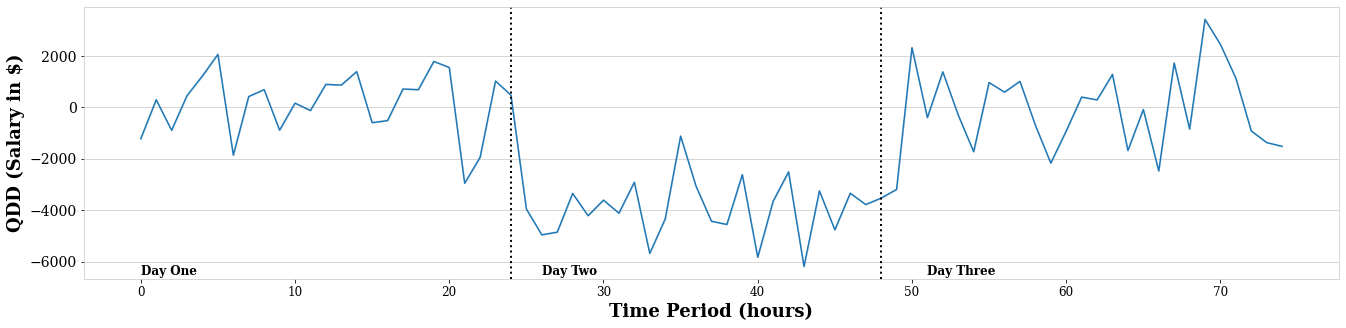

In [278]:
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams['axes.edgecolor'] = "#cccccc"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
plt.rcParams["font.family"] = 'DejaVu Serif'
plt.rcParams["figure.figsize"] = (22.5,5)

sns.lineplot(data=monitoring_df, x='period', y='mean_score_period')

ax = plt.gca()
ax.set_facecolor('white')
# ax.get_legend().remove()
ax.xaxis.grid(False)
# if log == True:
#     ax.set(yscale="symlog")
ax.yaxis.grid(True,which='both')
ax.tick_params(axis='y', which='both',labelsize=14)
ax.tick_params(axis='x', which='both',labelsize=12)
plt.axvline(x=24,  color='black', ls=':', lw=2)
plt.axvline(x=48,  color='black', ls=':', lw=2)

plt.annotate('Day One', xy =(12, -6000), xytext =(0, -6500),fontsize=12,weight='bold')
plt.annotate('Day Two', xy =(12, -6000), xytext =(26, -6500),fontsize=12,weight='bold')
plt.annotate('Day Three', xy =(12, -6000), xytext =(51, -6500),fontsize=12,weight='bold')


  
plt.xlabel('Time Period (hours)',fontsize=18,weight='bold') 
plt.ylabel('QDD (Salary in $)',fontsize=18,weight='bold') 

plt.savefig('QDD_casestudy.pdf',bbox_inches='tight')

# Shapley


#### Expected value difference

### During a period of artificial drift

In [304]:
#target = monitoring_df[monitoring_df['period'] == 22][feature_cols].values
#reference = transform_input(df.sample(n=100, random_state=1)[feature_cols]).values
day = 1

target = monitoring_df[(monitoring_df['day'] == day) & (monitoring_df['gender'] == 0.0)][feature_cols].sample(n=9000, random_state=1).values
reference = monitoring_df[(monitoring_df['day'] == day) & (monitoring_df['gender'] == 1.0)][feature_cols].sample(n=9000, random_state=1).values

target_torch = torch.tensor(target.astype('float'), dtype=torch.float64)
reference_torch = torch.tensor(reference.astype('float'), dtype=torch.float64)

target_pred = model_linear(target_torch).detach().numpy()
reference_pred = model_linear(reference_torch).detach().numpy()

print(np.mean(target_pred) - np.mean(reference_pred))

def drift_score_fn(target, reference):
    target_pred = model_linear(target)
    reference_pred = model_linear(reference)
    return drift_metrics.mean_drift_score(target_pred.detach().numpy(), reference_pred.detach().numpy())

attrs = drift_attribution.drift_shapley_group_approximation(reference_torch, target_torch, drift_score_fn, group_sizes=None)
print(f'Shap values for model are {attrs}') 

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


156.19533333333675
Shap values for model are [[-146.66666667  264.44444444  127.25555556    3.38422222  -92.22222222]]


### Plot this for drift

In [305]:
attrsDF = pd.DataFrame(data=attrs, columns=feature_cols)

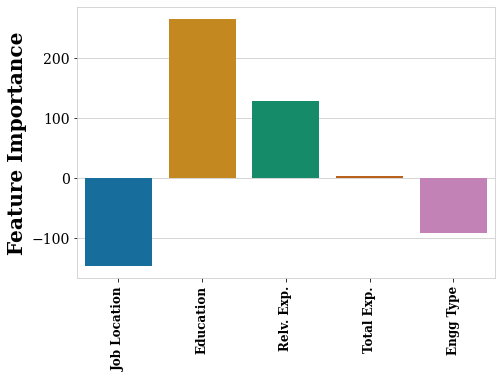

In [306]:
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams['axes.edgecolor'] = "#cccccc"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
plt.rcParams["font.family"] = 'DejaVu Serif'
plt.rcParams["figure.figsize"] = (7.5,5)

sns.barplot(data=attrsDF,zorder=3,palette = 'colorblind')

ax = plt.gca()
ax.set_facecolor('white')
# ax.get_legend().remove()
ax.xaxis.grid(False)
# if log == True:
#     ax.set(yscale="symlog")
labels = ['Job Location', 'Education', 'Relv. Exp.', 'Total Exp.', 'Engg Type']
ax.set_xticklabels(labels,rotation = 90,weight='bold')
ax.xaxis.set_tick_params(labelsize=24)
ax.yaxis.grid(True,which='both')
ax.tick_params(axis='y', which='both',labelsize=14)
ax.tick_params(axis='x', which='both',labelsize=12)
# plt.xlabel('Time Period (hours)',fontsize=18,weight='bold') 
plt.ylabel('Feature Importance',fontsize=20,weight='bold') 

plt.savefig('Explanations_day1.pdf',bbox_inches='tight')

### During a period of no drift

In [86]:
#target = monitoring_df[monitoring_df['period'] == 22][feature_cols].values
#reference = transform_input(df.sample(n=100, random_state=1)[feature_cols]).values


target = monitoring_df[(monitoring_df['day'] == 1) & (monitoring_df['gender'] == 1.0)][feature_cols].sample(n=9000, random_state=1).values
reference = monitoring_df[(monitoring_df['day'] == 1) & (monitoring_df['gender'] == 0.0)][feature_cols].sample(n=9000, random_state=1).values

target_torch = torch.tensor(target.astype('float'), dtype=torch.float64)
reference_torch = torch.tensor(reference.astype('float'), dtype=torch.float64)

target_pred = model_linear(target_torch).detach().numpy()
reference_pred = model_linear(reference_torch).detach().numpy()

print(np.mean(target_pred) - np.mean(reference_pred))

def drift_score_fn(target, reference):
    target_pred = model_linear(target)
    reference_pred = model_linear(reference)
    return drift_metrics.mean_drift_score(target_pred.detach().numpy(), reference_pred.detach().numpy())

attrs = drift_attribution.drift_shapley_group_approximation(reference_torch, target_torch, drift_score_fn, group_sizes=None)
print(f'Shap values for model are {attrs}') 

/home/avijit/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


-156.19533333333675
Shap values for model are [[ 146.66666667 -264.44444444 -127.25555556   -3.38422222   92.22222222]]


In [41]:
attrs

array([[ 146.66666667, -264.44444444, -127.25555556,   -3.38422222,
          92.22222222]])

### Plot this for no drift


<AxesSubplot:>

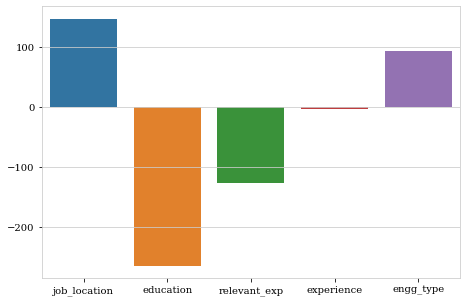

In [82]:
attrsDF = pd.DataFrame(data=attrs, columns=feature_cols)
sns.barplot(data=attrsDF)